##### Date: 09/22/2021
##### Data Reference: KDD99 dataset (http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) 
##### Python library: pandas, numpy, seaborn, matplotlib, sklearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing,metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
options = dict(compression='gzip',header=None)
train_data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz',**options)
test_data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz',**options)
columns = train_data.columns

In [3]:
train_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
test_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [5]:
train_data.shape, test_data.shape

((4898431, 42), (311029, 42))

In [6]:
'''
filter data to subset of balance train train
'''
prob_str = '(?=.*ipsweep|nmap|portsweep|satan)'
cond = train_data[41].str.contains(prob_str) # get all probes
print('counts of prob: ',cond.sum()) # probes is unbalance
probe_index = np.where(cond==True)[0]
np.random.seed(2) # fix random choice
no_probe = np.random.randint(train_data.shape[0],size=35000) # randomly choice 50000 no probe
print('# intersect of probe and no probe: ',np.in1d(no_probe,probe_index).sum())
print('='*80)
print("This is okay, because we don't want the dataset is extremely unbalance")
print('='*80)
train_df = (train_data.loc[np.concatenate((probe_index,no_probe))]
                            .reset_index(drop=1)
                            .drop_duplicates())
train_targets = train_df[41].unique()
print('use for train target list:\n',train_targets)
test_df = (test_data.loc[(test_data[41].str.contains('(?=.*{})'.format('|'.join(train_targets))))&
                            ~(test_data[2].isin(['tim_i','icmp','tftp_u']))]
                        .reset_index(drop=1)
                        .drop_duplicates())
print('='*80)
print('The probe has many duplicate values so it reduces to:',train_df[41].str.contains(prob_str).sum())
print('The total training sample size is:',train_df.shape[0])

'''
encode characters/words into numerical values
'''
encodes = []
for i in range(1,4):
    encodes.append(preprocessing.LabelEncoder())
    train_df[41+i] = encodes[i-1].fit_transform(train_df[i])
    test_df[41+i] = encodes[i-1].transform(test_df[i])

'''
turn target words into binary values
'''
train_df[45] = train_df[41].str.contains(prob_str).astype(int)
test_df[45] = test_df[41].str.contains(prob_str).astype(int)

'''
1. getting the train X and corresponding y and test X and corresponding y values

2. standardize all features
'''

x_index=[0]+train_df.columns[4:41].tolist()+[42,43,44,45,1,2,3,41] # reorder columns
train_df = train_df[x_index]
test_df = test_df[x_index]
standard = preprocessing.StandardScaler()
features = train_df.columns[:41] #all features columns total 40
X_train,X_valid,y_train,y_valid = train_test_split(standard.fit_transform(train_df[features].values),
                                                   train_df[45].values,test_size=0.2,
                                                   random_state=1, stratify=train_df[45].values)
X_test,y_test = standard.transform(test_df[features].values),test_df[45]

counts of prob:  41102
# intersect of probe and no probe:  300
This is okay, because we don't want the dataset is extremely unbalance
use for train target list:
 ['portsweep.' 'ipsweep.' 'satan.' 'nmap.' 'smurf.' 'neptune.' 'normal.'
 'teardrop.' 'back.' 'warezclient.' 'guess_passwd.' 'pod.' 'land.']
The probe has many duplicate values so it reduces to: 13860
The total training sample size is: 27384


[LibLinear]

|+|Training accuracy: 	96.13%


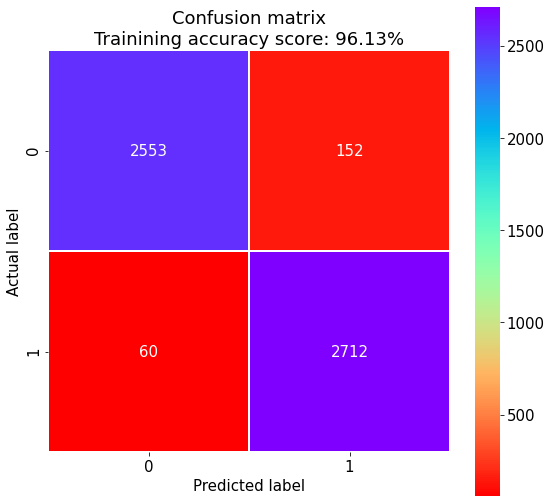

In [7]:
logit = LogisticRegression(penalty='l2',tol=0.0001,C=1.0,random_state=0,
                           solver='liblinear', multi_class='ovr',max_iter=100,verbose=1)
logit.fit(X_train, y_train)
valid_score = np.round(logit.score(X_valid,y_valid)*100,2)
test_score = np.round(logit.score(X_test,y_test)*100,2)
print('\n')
print('='*30)
print(f"|+|Training accuracy: \t{valid_score}%")
print('='*30)
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_valid,logit.predict(X_valid)),
            annot=True, fmt=".0f",linewidths=.5,square = True, cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTrainining accuracy score: {}%'.format(valid_score),size=18)
plt.show()

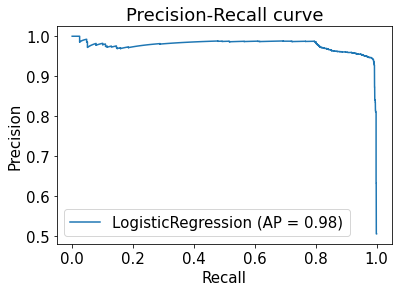

In [8]:
disp = metrics.plot_precision_recall_curve(logit,X_valid, y_valid)
disp.ax_.set_title('Precision-Recall curve')
plt.show()

|+|Testing accuracy: 	98.21%


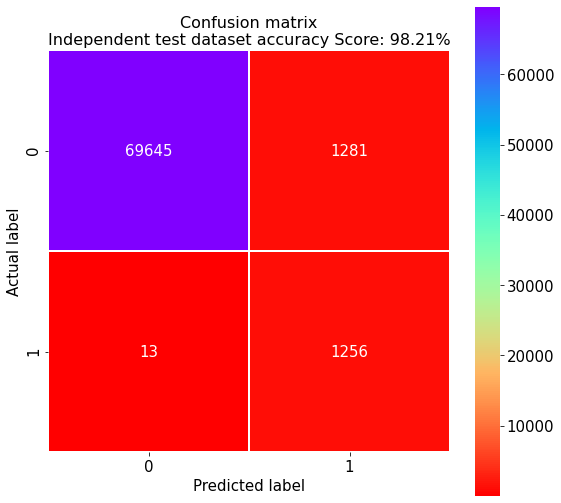

In [9]:
print('='*30)
print(f"|+|Testing accuracy: \t{test_score}%")
print('='*30)
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test,logit.predict(X_test)),
            annot=True, fmt=".0f",linewidths=.5,square = True, cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nIndependent test dataset accuracy Score: {}%'.format(test_score),size=16)
plt.show()

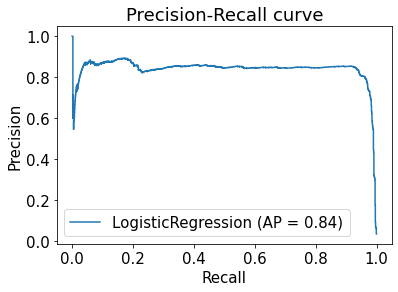

In [10]:
disp = metrics.plot_precision_recall_curve(logit,X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')
plt.show()

###### The training data was chosen to be balance and use cross-validation data. The model is not overfitting becuase based on the confusion matrix and precision-recall curve from above for validation set and independent test set, the model does pretty great job to identify probe vs non-probe. Especially, the model does a great job on independent dataset, this means our model is a good model

In [11]:
print(f"Number of iteration of convergence: {logit.n_iter_[0]}")

Number of iteration of convergence: 8


In [12]:
print("3 features have the largest weights in absolute value: ")
feat_index = np.lexsort(np.abs(logit.coef_))[::-1]
for i in range(3):
    print('='*80)
    temp = train_df[train_df.columns[feat_index[i]]].unique()
    print(f'#{i+1} feature weight: {logit.coef_[0,feat_index[i]]};'
          f'\tUnique counts for the features:{temp.shape[0]}')
    print(f'\tUnique values for the features: {temp}')

3 features have the largest weights in absolute value: 
#1 feature weight: 2.817441352425263;	Unique counts for the features:11
	Unique values for the features: [ 1  4  2  3  5  9 10  0  7  8  6]
#2 feature weight: 2.256687142217169;	Unique counts for the features:79
	Unique values for the features: [0.   0.67 0.5  0.6  0.57 0.56 0.55 0.54 0.53 0.52 0.58 0.59 1.   0.75
 0.71 0.62 0.46 0.47 0.44 0.42 0.45 0.43 0.41 0.4  0.39 0.38 0.37 0.36
 0.04 0.99 0.98 0.97 0.96 0.95 0.33 0.29 0.25 0.22 0.2  0.18 0.17 0.15
 0.14 0.13 0.12 0.11 0.16 0.1  0.64 0.78 0.8  0.82 0.31 0.28 0.26 0.24
 0.23 0.27 0.69 0.09 0.3  0.73 0.77 0.21 0.19 0.32 0.35 0.08 0.06 0.07
 0.05 0.03 0.02 0.01 0.61 0.51 0.83 0.7  0.79]
#3 feature weight: -2.1255323484997612;	Unique counts for the features:2
	Unique values for the features: [0 1]


###### It does make sense for the largest weight with 10 unique values in one feature and it has a small variance. And similar to the second largest feature. Lastly, the binary feature does contribute the negative effect to the weight. Which also makes sense. 

[LibLinear]

|+|Training accuracy: 	96.13%


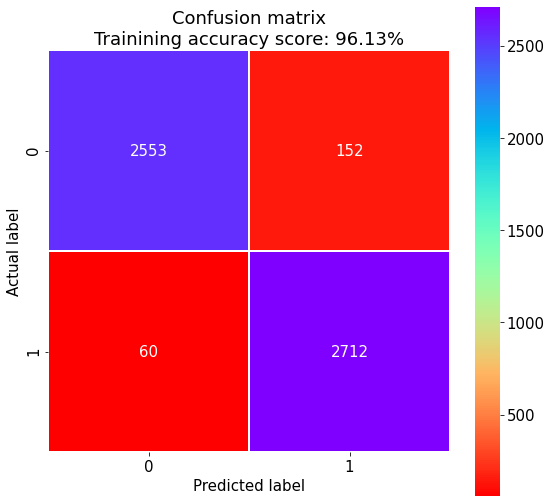

In [13]:
logit_l1 = LogisticRegression(penalty='l1',tol=0.0001,C=1.0,random_state=0,
                           solver='liblinear', multi_class='ovr',max_iter=100,verbose=1)
logit_l1.fit(X_train, y_train)
valid_score = np.round(logit_l1.score(X_valid,y_valid)*100,2)
test_score = np.round(logit_l1.score(X_test,y_test)*100,2)
print('\n')
print('='*30)
print(f"|+|Training accuracy: \t{valid_score}%")
print('='*30)
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_valid,logit_l1.predict(X_valid)),
            annot=True, fmt=".0f",linewidths=.5,square = True, cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nTrainining accuracy score: {}%'.format(valid_score),size=18)
plt.show()

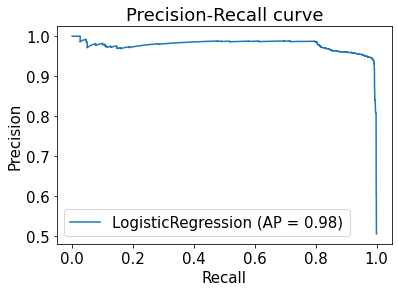

In [14]:
disp = metrics.plot_precision_recall_curve(logit_l1,X_valid, y_valid)
disp.ax_.set_title('Precision-Recall curve')
plt.show()

|+|Testing accuracy: 	98.2%


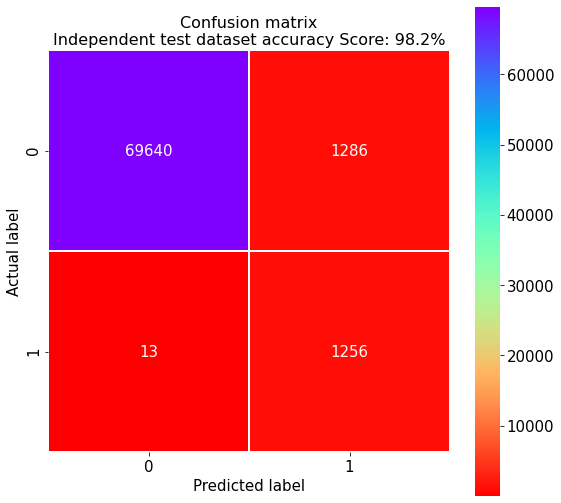

In [15]:
print('='*30)
print(f"|+|Testing accuracy: \t{test_score}%")
print('='*30)
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test,logit_l1.predict(X_test)),
            annot=True, fmt=".0f",linewidths=.5,square = True, cmap='rainbow_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix\nIndependent test dataset accuracy Score: {}%'.format(test_score),size=16)
plt.show()

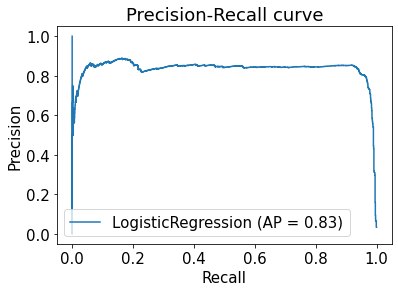

In [16]:
disp = metrics.plot_precision_recall_curve(logit_l1,X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')
plt.show()

In [17]:
print(f"Number of iteration of convergence: {logit_l1.n_iter_[0]}")

Number of iteration of convergence: 23


In [18]:
print("3 features have the largest weights in absolute value: ")
feat_index = np.lexsort(np.abs(logit_l1.coef_))[::-1]
for i in range(3):
    print('='*80)
    temp = train_df[train_df.columns[feat_index[i]]].unique()
    print(f'#{i+1} feature weight: {logit_l1.coef_[0,feat_index[i]]};'
          f'\tUnique counts for the features:{temp.shape[0]}')
    print(f'\tUnique values for the features: {temp}')

3 features have the largest weights in absolute value: 
#1 feature weight: 2.86776259692887;	Unique counts for the features:11
	Unique values for the features: [ 1  4  2  3  5  9 10  0  7  8  6]
#2 feature weight: 2.2670183578624963;	Unique counts for the features:79
	Unique values for the features: [0.   0.67 0.5  0.6  0.57 0.56 0.55 0.54 0.53 0.52 0.58 0.59 1.   0.75
 0.71 0.62 0.46 0.47 0.44 0.42 0.45 0.43 0.41 0.4  0.39 0.38 0.37 0.36
 0.04 0.99 0.98 0.97 0.96 0.95 0.33 0.29 0.25 0.22 0.2  0.18 0.17 0.15
 0.14 0.13 0.12 0.11 0.16 0.1  0.64 0.78 0.8  0.82 0.31 0.28 0.26 0.24
 0.23 0.27 0.69 0.09 0.3  0.73 0.77 0.21 0.19 0.32 0.35 0.08 0.06 0.07
 0.05 0.03 0.02 0.01 0.61 0.51 0.83 0.7  0.79]
#3 feature weight: -2.1530290629852673;	Unique counts for the features:2
	Unique values for the features: [0 1]


###### Comparing L1 vs L2:
1. Both training accuracy is the same but L2 has better testing accuracy. Which is 0.01%, no significantly different. 
2. Both have the same precision-recall for the validation set but L2 has better precision-recall. Which is 2%, no significantly different.
3. Number of iteration of convergence for L2 is 8 but L1 takes 23. Which means L1 take longer time to converge
4. Both have same ranking for feature weight

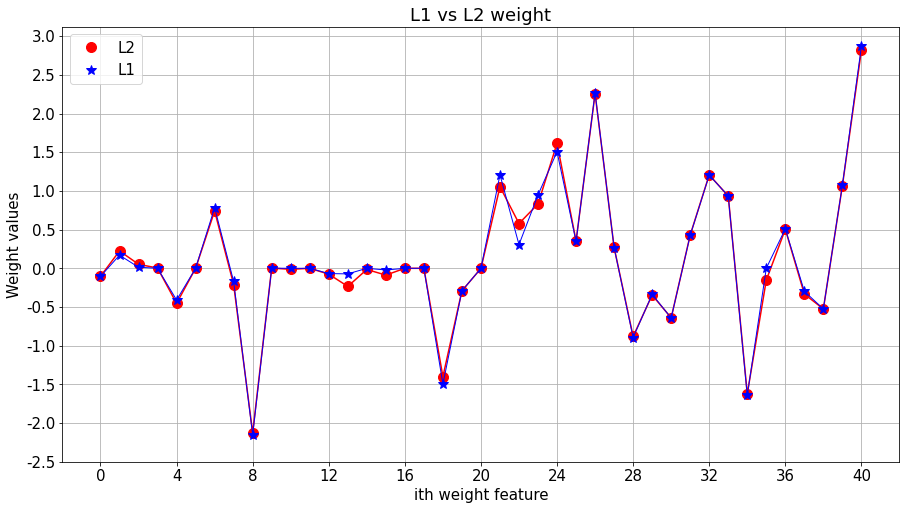

In [19]:
fig,ax = plt.subplots(figsize=(15,8))
x = np.arange(logit.coef_.shape[1])
yticks = np.linspace(-2.5,3,12)
ax.plot(x,logit.coef_[0],'o',markersize=10,label='L2',linewidth=1,color='r')
ax.plot(x,logit.coef_[0],color='r')
ax.plot(x,logit_l1.coef_[0],'*',markersize=10,label='L1',color='b')
ax.plot(x,logit_l1.coef_[0],linewidth=1,color='b')
ax.set(xlabel="ith weight feature",xticks=x[::4],xticklabels=x[::4],
       ylabel='Weight values',yticks= yticks, yticklabels=yticks,
       title='L1 vs L2 weight')
ax.grid(True)
ax.legend()
plt.show()

[LibLinear]

********************************************************************************
********************************************************************************
Regularization strength: 0.001
|+|Testing accuracy: 	97.64%


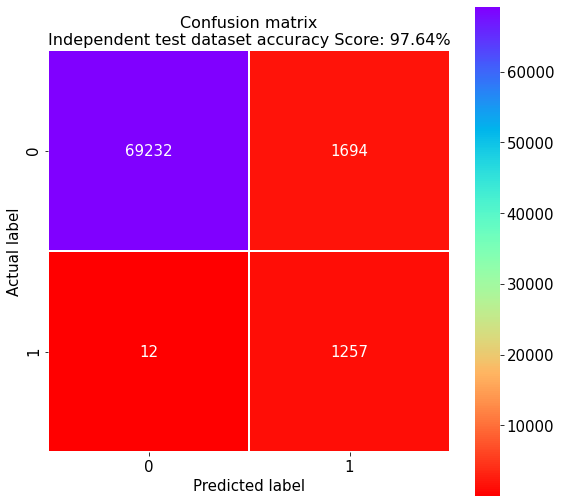

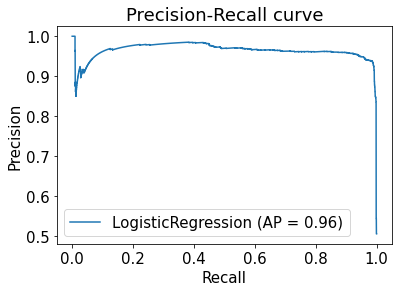

Number of iteration of convergence: 5
[LibLinear]

********************************************************************************
********************************************************************************
Regularization strength: 0.01
|+|Testing accuracy: 	97.64%


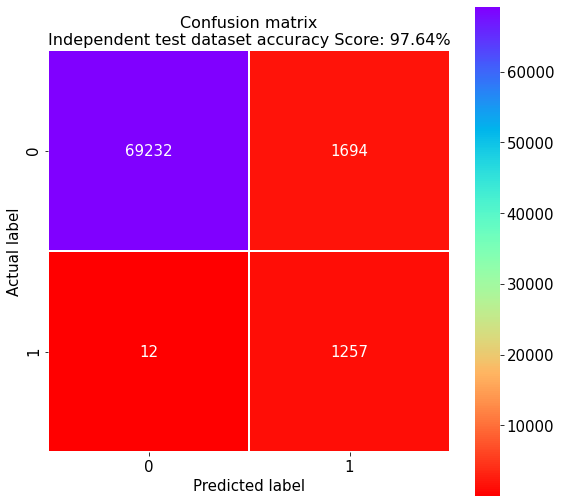

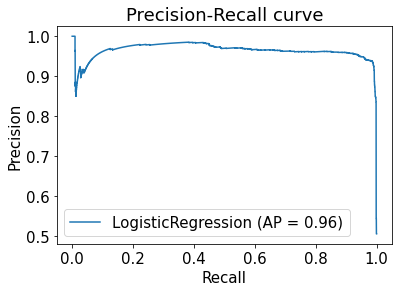

Number of iteration of convergence: 5
[LibLinear]

********************************************************************************
********************************************************************************
Regularization strength: 0.1
|+|Testing accuracy: 	97.64%


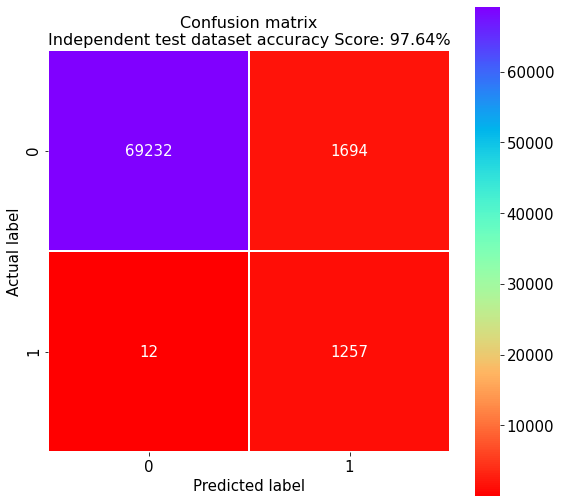

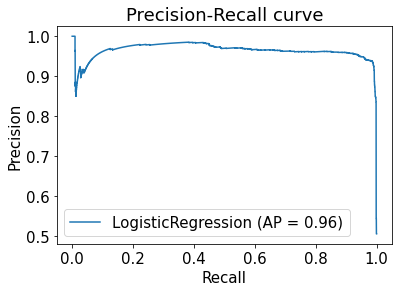

Number of iteration of convergence: 5
[LibLinear]

********************************************************************************
********************************************************************************
Regularization strength: 10
|+|Testing accuracy: 	97.64%


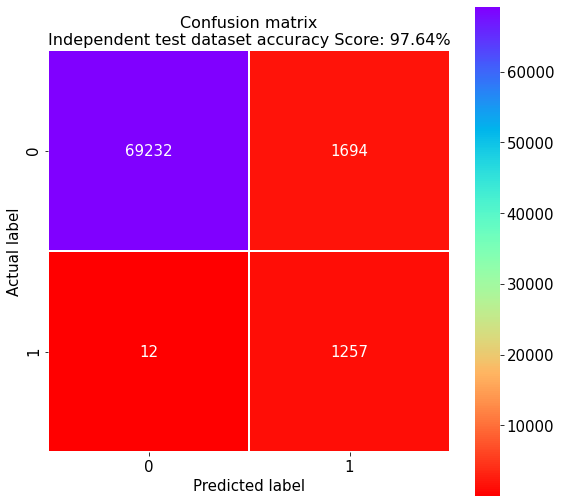

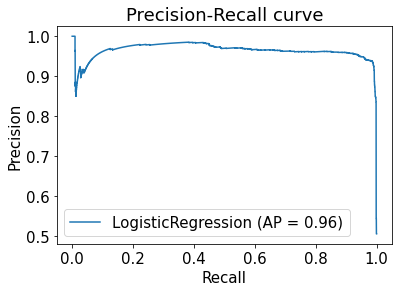

Number of iteration of convergence: 5


In [20]:
for i in [.001, .01,.1,10]:
    logit = LogisticRegression(penalty='l2',tol=0.0001,C=0.001,random_state=0,
                               solver='liblinear', multi_class='ovr',max_iter=100,verbose=1)
    logit.fit(X_train, y_train)
    valid_score = np.round(logit.score(X_valid,y_valid)*100,2)
    test_score = np.round(logit.score(X_test,y_test)*100,2)
    print('\n')
    print('*'*80)
    print('*'*80)
    print(f'Regularization strength: {i}')
    print('='*30)
    print(f"|+|Testing accuracy: \t{test_score}%")
    print('='*30)
    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(9,9))
    sns.heatmap(metrics.confusion_matrix(y_test,logit.predict(X_test)),
                annot=True, fmt=".0f",linewidths=.5,square = True, cmap='rainbow_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix\nIndependent test dataset accuracy Score: {}%'.format(test_score),size=16)
    plt.show()

    disp = metrics.plot_precision_recall_curve(logit,X_valid, y_valid)
    disp.ax_.set_title('Precision-Recall curve')
    plt.show()
    print(f"Number of iteration of convergence: {logit.n_iter_[0]}")
    del logit

##### comparing different regularization strength for L2 with .001, .01, .1, 1, 10
1. Testing accuracies are same for .001, .01, .1, 10 but the best is 1
2. Using .001, .01, .1, 10 have the same precision-recall but using 1 is better precision-recall
3. Using .001, .01, .1, 10 takes 5 iteration to converge but for 1 takes 8 iteration. Which means L1 take longer time to converge

Based on the experience, regularization strength (C=1) is the best choice but it takes longer time. So there is some trade off for accuracy and traing time consuming. Also, L2 is doing better than L1 if we use same parameters.
our logistic regression model does a great job on this dataset but the remake is how we have done in the data preprocessing. Since the dataset is exmtremely unbalanced and many duplicate values, we need to remove the duplicate values and make the dataset balance. In additional, all features are used for training our model including these string value, we have use some encoding methods to turning characters into numerical values. The simplest way is hot encoding, where we have used. 
Lastly, the logistic regression is really great tool to predict some continuous data